In [124]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [117]:
import os

In [118]:
with open('batch3.pkl', 'rb') as file:
    batch3 = pickle.load(file)
with open('batch2.pkl', 'rb') as file:
    batch2 = pickle.load(file)
with open('batch1.pkl', 'rb') as file:
    batch1 = pickle.load(file)


In [119]:
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [6]:
batch1.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

In [7]:

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]



In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']



In [9]:
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [10]:
numBat = len(batch1.keys()) + len(batch2.keys()) + len(batch3.keys())
bat_dict = {**batch1, **batch2, **batch3}
numBat

124

Text(0, 0.5, 'Discharge Capacity (Ah)')

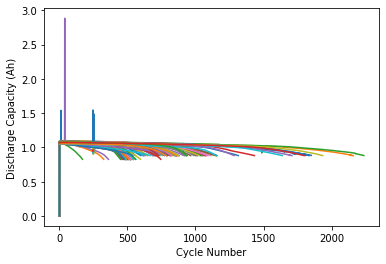

In [11]:
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [12]:
bat_dict['b1c1'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [170]:
import pandas as pd

bat_dfs = {}

for bat in bat_dict.keys():
    data_for_df = []
    for cycle_num in range(len(bat_dict[bat]['cycles'])):
        idx_switch = -1
        for idx in np.where(bat_dict[bat]['cycles'][str(cycle_num)]['I'] < 0)[0]:
            if (bat_dict[bat]['cycles'][str(cycle_num)]['I'][idx+1] < 0) and (bat_dict[bat]['cycles'][str(cycle_num)]['I'][idx+2] < 0) and (bat_dict[bat]['cycles'][str(cycle_num)]['I'][idx+10] < 0):
                idx_switch = idx
                break
        capacity = np.concatenate((bat_dict[bat]['cycles'][str(cycle_num)]['Qc'][:idx_switch], bat_dict[bat]['cycles'][str(cycle_num)]['Qc'][idx_switch - 1] - bat_dict[bat]['cycles'][str(cycle_num)]['Qd'][idx_switch:]))
        for point_idx in range(len(bat_dict[bat]['cycles'][str(cycle_num)]['I'])):
            data_for_df.append([
                bat_dict[bat]['cycles'][str(cycle_num)]['I'][point_idx],
                bat_dict[bat]['cycles'][str(cycle_num)]['V'][point_idx],
                bat_dict[bat]['cycles'][str(cycle_num)]['T'][point_idx],
                bat_dict[bat]['cycles'][str(cycle_num)]['t'][point_idx],
                capacity[point_idx],
                cycle_num
            ])
    df = pd.DataFrame(data=data_for_df, columns=['I', 'V', 'T', 't', 'Q', 'c'])
    bat_dfs[bat] = df

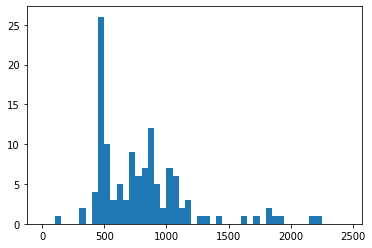

In [147]:
data = [bat_dict[bat]['cycle_life'][0][0] for bat in bat_dict.keys()]

counts, bins, _ = plt.hist(data, list(range(0, 2500, 50)))

In [148]:
from sklearn.model_selection import train_test_split

data = bat_dict

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'key'})
df['cycle_life'] = df['cycle_life'].apply(lambda x: x[0][0])

number_of_bins = 5
df['cycle_life_bins'] = pd.cut(df['cycle_life'], bins=number_of_bins, labels=False)

train_set, temp_set = train_test_split(df, test_size=0.4, stratify=df['cycle_life_bins'], random_state=42)
test_set, val_set = train_test_split(temp_set, test_size=0.5, stratify=temp_set['cycle_life_bins'], random_state=42)



In [149]:
def dataframe_to_dict(df):
    df = df.set_index('key')
    return df.to_dict(orient='index')

# Convert train_set to a dict of dicts
train_dict = dataframe_to_dict(train_set)
test_dict = dataframe_to_dict(test_set)
val_dict = dataframe_to_dict(val_set)

74


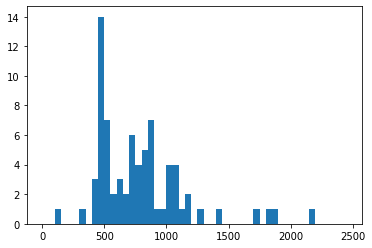

In [151]:
# plot train set
data = [train_dict[bat]['cycle_life'] for bat in train_dict.keys()]
counts, bins, _ = plt.hist(data, list(range(0, 2500, 50)))
print(len(train_dict))

25


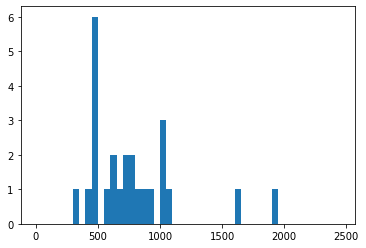

In [152]:
# plot test set
data = [test_dict[bat]['cycle_life'] for bat in test_dict.keys()]
counts, bins, _ = plt.hist(data, list(range(0, 2500, 50)))
print(len(test_dict))

25


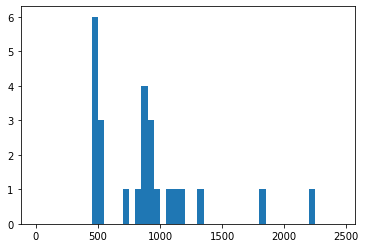

In [153]:
# plot val set
data = [val_dict[bat]['cycle_life'] for bat in val_dict.keys()]
counts, bins, _ = plt.hist(data, list(range(0, 2500, 50)))
print(len(val_dict))

In [179]:
import wandb

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import wandb
from skopt import BayesSearchCV
class Model(nn.Module):
    def __init__(self, num_layers, num_units, activation_fn):
        super().__init__()
        layers = []
        prev_units = 3  # Number of input features (I, V, T)
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_units, num_units).float())
            layers.append(self.get_activation(activation_fn))
            prev_units = num_units
        layers.append(nn.Linear(prev_units, 1))
        self.layers = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        x = self.sigmoid(x)
        return x

    def get_activation(self, activation_fn):
        if activation_fn == "relu":
            return nn.ReLU()
        elif activation_fn == "tanh":
            return nn.Tanh()
        elif activation_fn == "softmax":
            return nn.Softmax(dim=-1)
        elif activation_fn == "sigmoid":
            return nn.Sigmoid()
        else:
            raise ValueError(f"Invalid activation function: {activation_fn}")


def train_and_evaluate(params):
    num_layers = int(params[0])
    num_units = int(params[1])
    activation_fn = params[2]
    batch_size = int(params[3])
    learning_rate = params[4]

    model = Model(num_layers, num_units, activation_fn)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
        for start in batch_start:
            X_batch = X_train[start : start + batch_size]
            X_batch_tensor = torch.from_numpy(X_batch).float()
            y_batch = y_train[start : start + batch_size]
            y_batch_tensor = torch.from_numpy(y_batch).float()
            y_pred = model(X_batch_tensor)
            loss = loss_fn(y_pred, y_batch_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

    y_pred_val = model(torch.from_numpy(X_val).float()).cpu().detach().numpy()
    rmse = mean_squared_error(y_test_tensor, y_pred, squared=False)

    return -rmse  # Negative sign because skopt minimizes the objective function



In [184]:

sweep_config = {
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "RMSE"},
    'parameters': {
        'num_layers': {
            'values': [2,3,4,5]
        },
        'num_units': { # just 500 for now
           'min': 50,
            'max': 500
        },
        'activation': {
            'values': ['relu', 'tanh', 'softmax', 'sigmoid']
        },
        'batch_size': { # list 2^n
            'value':[4, 8, 16, 32, 64, 128]
        },
        'learning_rate': {
            'min': 1e-4,
            'max': 1e-2
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="batteries")


Create sweep with ID: droeomwu
Sweep URL: https://wandb.ai/zoeli/batteries/sweeps/droeomwu


In [185]:
features = ['I', 'V', 'T']
label = 'Q'

train_bats = ['b2c30']
test_bats = ['b2c5']
finetune_bats = ['b2c13']
train_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1) & (bat_dfs[bat]['c'] <= 30)] for bat in train_bats]
test_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1) & (bat_dfs[bat]['c'] <= 30)] for bat in test_bats]
finetune_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1)] for bat in finetune_bats]
train_df = pd.concat(train_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)
finetune_df = pd.concat(finetune_dfs).reset_index(drop=True)

# train_bats = train_set['key'].tolist()
# test_bats = test_set['key'].tolist()
# finetune_bats = val_set['key'].tolist()

# train_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1) & (bat_dfs[bat]['c'] <= 30)] for bat in train_bats]
# test_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1) & (bat_dfs[bat]['c'] <= 30)] for bat in test_bats]
# finetune_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1)] for bat in finetune_bats]

# train_df = pd.concat(train_dfs).reset_index(drop=True)
# test_df = pd.concat(test_dfs).reset_index(drop=True)
# finetune_df = pd.concat(finetune_dfs).reset_index(drop=True)

n_epochs = 3
wandb.init()

best_params = wandb.agent(sweep_id, function=train_and_evaluate)

print("Best Hyperparameters:", best_params)


Traceback (most recent call last):
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 1150, in init
    wi.setup(kwargs)
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 216, in setup
    tel.feature.set_init_tags = True
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 710, in _telemetry_callback
    self._telemetry_flush()
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 721, in _telemetry_flush
    self._backend.interface._publish_telemetry(self._telemetry_obj)
  File "/Users/lizihan/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 101, in _publish_telemetry
    self._publish(rec)
  File "/Users/lizihan/opt

Error: An unexpected error occurred

In [101]:
train_bats = ['b2c30']
train_dfs = [bat_dfs[bat][(bat_dfs[bat]['c'] >= 1) & (bat_dfs[bat]['c'] <= 30)] for bat in train_bats]
train_df = pd.concat(train_dfs).reset_index(drop=True)
train_df[features]

,I,V,T
0,0.000000,2.408364,31.028929
1,0.311905,2.422045,31.028929
2,0.520290,2.436257,31.028929
3,0.728350,2.453688,31.028929
4,0.988153,2.478853,31.028929
...,...,...,...
35896,0.000000,2.398058,31.056990
35897,0.000000,2.399161,31.058382
35898,0.000000,2.400301,31.058382
35899,0.000000,2.400301,31.065056
